# Exploration 12. 트랜스포머로 만드는 대화형 챗봇 👩‍🚀
영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

## Step 1. 데이터 수집하기
Data: [송영숙님이 공개한 챗봇 데이터](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

In [1]:
# # 데이터 다운로드
# $ mkdir -p ~/aiffel/transformer_chatbot/data/
# $ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

In [2]:
# 필요한 라이브러리 설치
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
path_to_dataset = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv' 
data = pd.read_csv(path_to_dataset) 

print(path_to_dataset)

/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv


In [15]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [16]:
data.shape

(11823, 3)

In [17]:
data.isna().sum()

Q        0
A        0
label    0
dtype: int64

In [18]:
data['label'].unique()

array([0, 1, 2])

In [20]:
data[data['label'] == 0] # 일반적인 반응

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
5285,힘내야지,응원합니다!,0
5286,힘든 것 좀 끝났으면,다 지나갈 거예요.,0
5287,힘든 시기가 지나갔으면,다 지나갈 거예요.,0
5288,힘든 데도 날 도와준 사람,잊지말고 보답하세요.,0


In [21]:
data[data['label'] == 1] # 부정

,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요.,1
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요.,1
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요.,1
5293,10년 연예의끝,더 마음이 허하겠어요.,1
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요.,1
...,...,...,...
8855,힘듭니다.,어떤 말도 위로가 되지 않겠지만 힘내세요.,1
8856,힘이 될런지 모르겠지만,어떤 말도 위로가 되지 않겠지만 힘내세요.,1
8857,힘이 드네,어떤 말도 위로가 되지 않겠지만 힘내세요.,1
8858,힘이 없어,힘내세요!,1


In [22]:
data[data['label'] == 2] # 긍정

,Q,A,label
8860,짝사랑만큼 고통스러운 건 없겠지.,짝사랑 만큼 감정소모가 큰 건 없을 거예요.,2
8861,1년 넘게 만났는데 지금도 불타올라,정열적인 사랑을 하고 있나봐요.,2
8862,1년 동거 중인데 계속 좋아,서로 깊게 알게되면서 더 좋아졌나봅니다.,2
8863,1년 동거하고 결혼했어,축하합니다!,2
8864,1년 만났는데도 그 사람에 대해 잘 모르겠어,더 만나보세요.,2
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


- 라벨의 의미가 궁금해서 한번 묶어서 출력해보았더니 각각 일반, 부정, 긍정인 대화가 나오는 것을 볼 수 있습니다.

## Step 2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만,  
전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [23]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # [?.!,] 그룹을 찾아라
    sentence = re.sub(r'[" "]+', " ", sentence) # 띄어쓰기

    # (한글, 숫자, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣0-9a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip() # 맨 앞, 뒤 공백 제거 가능
    return sentence

#### - 전처리가 잘되는지 전후 비교 및 확인

In [26]:
df['A']

0                      하루가 또 가네요.
1                       위로해 드립니다.
2                     여행은 언제나 좋죠.
3                     여행은 언제나 좋죠.
4                      눈살이 찌푸려지죠.
                   ...           
11818          티가 나니까 눈치가 보이는 거죠!
11819               훔쳐보는 거 티나나봐요.
11820                      설렜겠어요.
11821    잘 헤어질 수 있는 사이 여부인 거 같아요.
11822          도피성 결혼은 하지 않길 바라요.
Name: A, Length: 11823, dtype: object

In [29]:
preprocess_sentence(df['A'].values[-1])

'도피성 결혼은 하지 않길 바라요 .'

In [30]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    
    inputs, outputs = [], []
    
    for i in range(len(df)-1):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(df['Q'].values[i]))
        outputs.append(preprocess_sentence(df['A'].values[i]))
        
    return inputs, outputs

In [31]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11822
전체 샘플 수 : 11822


In [32]:
import random

ran = random.randint(0, len(questions))

print('전처리 후의 {}번째 질문 샘플: {}'.format(ran+1, questions[ran]))
print('전처리 후의 {}번째 답변 샘플: {}'.format(ran+1, answers[ran]))

전처리 후의 2588번째 질문 샘플: 수염 기를까
전처리 후의 2588번째 답변 샘플: 길러도 어울리면 길러보세요 .


## Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다.  
하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

### (1) 단어장(Vocabulary) 만들기

In [33]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [34]:
tokenizer.subwords[:10]

[' .', ' ?', '거예요', '수_', '게_', '너무_', '더_', '거_', '좋아하는_', '는_']

In [35]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [36]:
print('START_TOKEN의 번호 :' , START_TOKEN, [tokenizer.vocab_size])
print('END_TOKEN의 번호 :' , END_TOKEN, [tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8161] [8161]
END_TOKEN의 번호 : [8162] [8162]


In [37]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8163


### (2) 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
#### tokenizer.encode()의 입력으로 사용해보기

In [40]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 40번째 질문 샘플: {}'.format(tokenizer.encode(questions[40])))
print('정수 인코딩 후의 40번째 답변 샘플: {}'.format(tokenizer.encode(answers[40])))

정수 인코딩 후의 40번째 질문 샘플: [7860, 1715, 319, 4878]
정수 인코딩 후의 40번째 답변 샘플: [1715, 10, 4632, 63, 3326, 5190, 83, 1]


In [41]:
questions[40]

'간만에 떨리니까 좋더라'

#### 질문과 답변 셋에 대해 모두 정수 인코딩을 수행하고, 이와 동시에 문장의 최대 길이를 설정해 패딩(padding) 하기

In [42]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 20
print(MAX_LENGTH)

20


In [43]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [44]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8163
필터링 후의 질문 샘플 개수: 11791
필터링 후의 답변 샘플 개수: 11791


### (3) 교사 강요(Teacher Forcing) 사용하기

In [45]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

### (1) Positional Encoding
- 문장의 위치(position) 정보 벡터를 인코딩합니다.

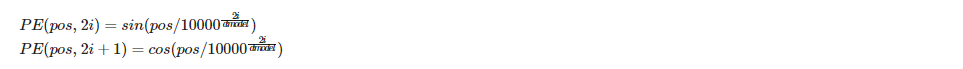

In [46]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### (2) Scaled Dot Product Attention
- 단어 사이의 유사도를 구해 학습 및 예측에 활용합니다.
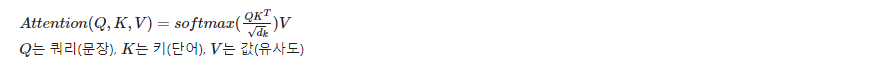

In [47]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32) # 실수형(float32)으로 변환(cast)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9) # 음의 무한대에 가까움
        
    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

### (3) 멀티 헤드 어텐션
- 어텐션을 병렬로 수행합니다
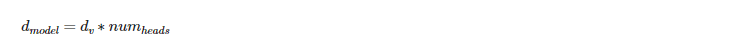

In [48]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0 # 나머지

        self.depth = d_model // self.num_heads # 몫 정수부분만

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### (4) Padding Masking
- 문장 길이를 동일하게 맞추기 위한 Padding시 채운 0 값을 연산에 사용하지 않습니다.
- 이를 위해 숫자 0인 위치를 체크합니다.

In [49]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32) # 0인 부분에서 1을 출력
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

### (5) Look-ahead masking
- 트랜스포머는 문장 행렬을 만들어 한 번에 행렬 형태로 입력에 들어가므로 순서를 마스킹 해주어야 합니다. 

In [50]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    
    return tf.maximum(look_ahead_mask, padding_mask)

### (6) Encoder
- 인코더 층은 크게 2개의 sublayer인 셀프 어텐션(입력 단어 - 입력 단어의 유사도)층과 피드 포워드 신경망(완전 연결층)으로 나뉩니다
- 입력 문장을 받아 정보를 얻고, 디코더에 전달하는 인코더(입력 처리)입니다.
- **인코더 셀프 어텐션**: **멀티 헤드 어텐션**으로 병렬적으로 이루어져 있습니다.

In [52]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 인코더 층: 임베딩 층(Embedding Layer)과 포지셔널 인코딩(Positional Encoding) 연결

In [54]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

## (7) Decoder
- 인코더에서 정보를 받아 문장을 생성하는 디코더(출력)입니다.
- 디코더는 총 3개의 sublayer로 구성됩니다.
- 디코더 셀프 어텐션(출력 단어 - 출력 단어의 유사도)층과 인코더 디코더 어텐션(입력 단어 - 출력 단어의 유사도)층, 그리고 완전연결층이 포함됩니다.

In [55]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

#### 디코더 층은 임베딩 층(Embedding Layer)과 포지셔널 인코딩(Positional Encoding) 을 연결한 후 원하는 만큼 디코더 층을 쌓아 완성

In [56]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

## (8) 트랜스포머 함수
- 인코더와 디코더를 결합합니다.

In [64]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Step 5. 모델 생성 및 훈련하기
### (1) 모델 생성

In [65]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3143936     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### (2) 손실 함수(Loss Function)
- 레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다

In [67]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### (3) 커스텀 된 학습률 (Learning rate)
- 모델학습 초기에 lr을 급격히 높혔다가 train step이 진행됨에 따라 서서히 낮추어 가며 안정적으로 수렴하게 하는 기법

In [68]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step) # 제곱근의 역수
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

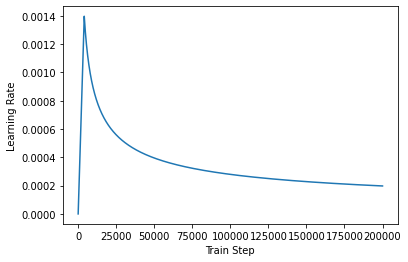

In [70]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### (4) 모델 컴파일

In [71]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [72]:
# 모델 훈련

EPOCHS = 20
history = model.fit(dataset, epochs = EPOCHS, verbose =1)

Epoch 1/20
185/185 [==============================] - 13s 37ms/step - loss: 2.9654 - accuracy: 0.0528
Epoch 2/20
185/185 [==============================] - 7s 36ms/step - loss: 2.4096 - accuracy: 0.1011
Epoch 3/20
185/185 [==============================] - 7s 36ms/step - loss: 2.0485 - accuracy: 0.1036
Epoch 4/20
185/185 [==============================] - 7s 36ms/step - loss: 1.8906 - accuracy: 0.1110
Epoch 5/20
185/185 [==============================] - 7s 37ms/step - loss: 1.7712 - accuracy: 0.1177
Epoch 6/20
185/185 [==============================] - 7s 37ms/step - loss: 1.6488 - accuracy: 0.1269
Epoch 7/20
185/185 [==============================] - 7s 37ms/step - loss: 1.5165 - accuracy: 0.1388
Epoch 8/20
185/185 [==============================] - 7s 37ms/step - loss: 1.3684 - accuracy: 0.1546
Epoch 9/20
185/185 [==============================] - 7s 37ms/step - loss: 1.2101 - accuracy: 0.1723
Epoch 10/20
185/185 [==============================] - 7s 37ms/step - loss: 1.0439 - accur

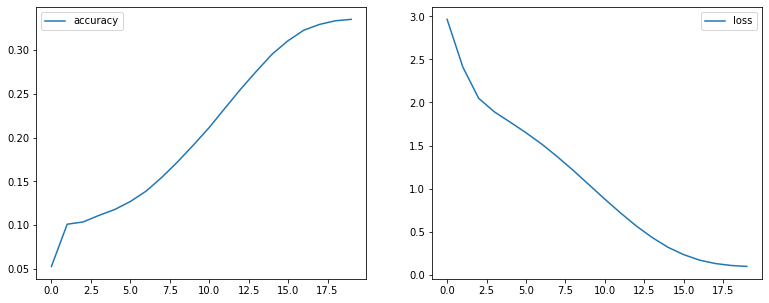

In [73]:
# 훈련 결과 시각화
plt.figure(figsize = (13, 5))

# 정확도
plt.subplot(121)
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.legend()

# 손실
plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.legend()

plt.show()

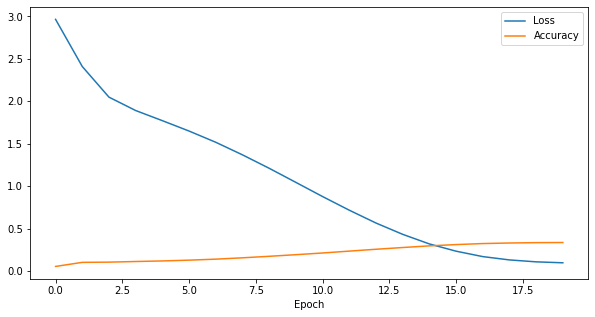

In [74]:
history.history

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'])

## Step 6. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [75]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [76]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [79]:
sentence_generation("오늘 기분이 어때?")

입력 : 오늘 기분이 어때?
출력 : 맛있는 거 먹고 기분다 보면 그럴 거 같아요 .


'맛있는 거 먹고 기분다 보면 그럴 거 같아요 .'

In [77]:
sentence_generation("오늘 뭐해?")

입력 : 오늘 뭐해?
출력 : 실내 데이트가 좋겠네요 .


'실내 데이트가 좋겠네요 .'

In [81]:
sentence_generation("힘들진 않아?")

입력 : 힘들진 않아?
출력 : 사람 마다 다르겠지요 .


'사람 마다 다르겠지요 .'

In [82]:
sentence_generation("공부하기 싫어")

입력 : 공부하기 싫어
출력 : 잠시 쉬어도 돼요 .


'잠시 쉬어도 돼요 .'

In [80]:
sentence_generation("안녕하세요")

입력 : 안녕하세요
출력 : 안녕하세요 .


'안녕하세요 .'

In [83]:
data[200:201]

,Q,A,label
200,골프 못 치는데,처음부터 잘하는 사람은 없어요.,0


## Epoch 늘려서 학습해보기

In [88]:
# 모델 훈련

EPOCHS = 50
history2 = model.fit(dataset, epochs = EPOCHS, verbose =1)

Epoch 1/50
185/185 [==============================] - 7s 37ms/step - loss: 0.0509 - accuracy: 0.3445
Epoch 2/50
185/185 [==============================] - 7s 37ms/step - loss: 0.0454 - accuracy: 0.3459
Epoch 3/50
185/185 [==============================] - 7s 37ms/step - loss: 0.0400 - accuracy: 0.3472
Epoch 4/50
185/185 [==============================] - 7s 36ms/step - loss: 0.0368 - accuracy: 0.3480
Epoch 5/50
185/185 [==============================] - 7s 37ms/step - loss: 0.0324 - accuracy: 0.3493
Epoch 6/50
185/185 [==============================] - 7s 37ms/step - loss: 0.0302 - accuracy: 0.3498
Epoch 7/50
185/185 [==============================] - 7s 37ms/step - loss: 0.0293 - accuracy: 0.3502
Epoch 8/50
185/185 [==============================] - 7s 37ms/step - loss: 0.0262 - accuracy: 0.3509
Epoch 9/50
185/185 [==============================] - 7s 37ms/step - loss: 0.0242 - accuracy: 0.3513
Epoch 10/50
185/185 [==============================] - 7s 37ms/step - loss: 0.0234 - accura

### 모델 평가하기

In [93]:
sentence_generation("오늘 기분이 어때?")

입력 : 오늘 기분이 어때?
출력 : 사랑에 나이는 중요하지 않아요 .


'사랑에 나이는 중요하지 않아요 .'

In [94]:
sentence_generation("오늘 뭐해?")

입력 : 오늘 뭐해?
출력 : 냉장고 파먹기 해보세요 .


'냉장고 파먹기 해보세요 .'

In [98]:
sentence_generation("오늘 뭐하니?")

입력 : 오늘 뭐하니?
출력 : 뜻대로 되는게 많지 않죠 .


'뜻대로 되는게 많지 않죠 .'

In [95]:
sentence_generation("공부하기 싫어")

입력 : 공부하기 싫어
출력 : 잠시 쉬어도 돼요 .


'잠시 쉬어도 돼요 .'

In [97]:
data.loc[[1235,1239]]

,Q,A,label
1235,더 나은 학교생활 하고 싶어,하루에 하나씩 변화해보세요.,0
1239,더우니까 무서운 이야기 듣고싶지,해주세요.,0


# 회고

1. 이번 프로젝트는 나름 수월하게 진행됐고 내용 자체가 재밌었다. 
2. 특히, 노드에 나와있지 않은 label을 가지고 대화 내용을 출력해보는 부분이 좀 흥미로웠다.
3. 처음에 학습한 결과는 아래처럼 조금 이상한 경우가 있었다, 
    - 입력 : 오늘 기분이 어때?
    - 출력 : 맛있는 거 먹고 기분다 보면 그럴 거 같아요 .
4. epoch를 늘려서 다시 학습해본 결과 로봇이 더 그럴싸한 답변을 하는지 보려고 다시 해봤는데 ... 여전히 이상했다.  
    - 입력 : 오늘 기분이 어때?
    - 출력 : 사랑에 나이는 중요하지 않아요 .
5. 뭐가 문제인지 확실하게는 모르겠지만 데이터 양이 11,000개로 많지가 않고, 모델 성능 자체가 낮기 때문인 것 같다. 
    -> 모델 layer를 더 쌓거나, 더욱더 정확한 데이터를 사용해보아야 할 것 같다 !!